In [1]:
import utils
from preprocessing import *
SIZE = 256

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
img_train, mask_train = prepareDataset(TRAIN_CONTOUR_PATH, TRAIN_IMG_PATH)

Number of examples: 260

Processing 260 images and labels ...



In [4]:
img_test, mask_test = prepareDataset(TEST_CONTOUR_PATH, TEST_IMG_PATH)

Number of examples: 279

Processing 279 images and labels ...



In [5]:
img_val, mask_val = prepareDataset(VAL_CONTOUR_PATH, VAL_IMG_PATH)

Number of examples: 266

Processing 266 images and labels ...



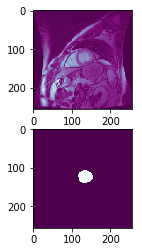

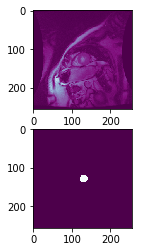

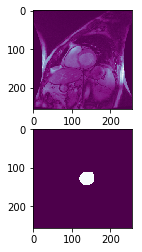

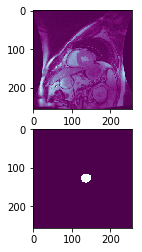

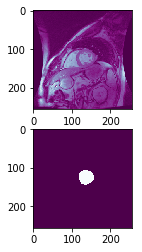

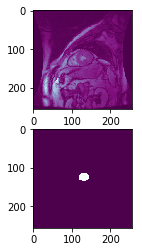

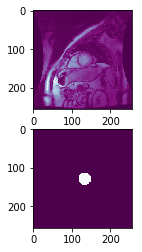

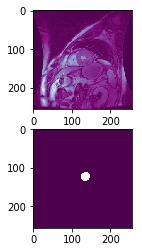

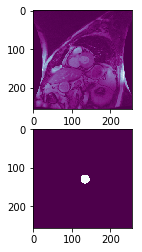

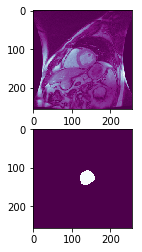

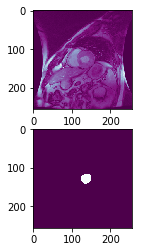

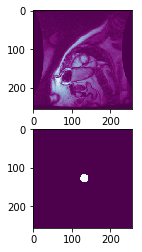

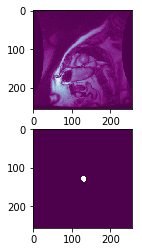

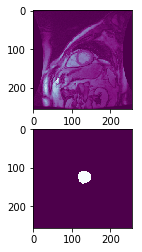

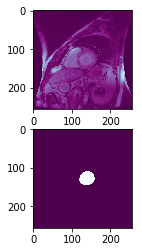

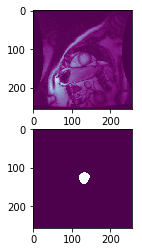

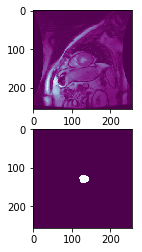

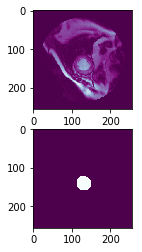

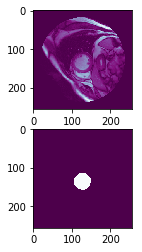

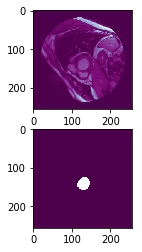

In [15]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
for i in range(20):
    mask = mask_train[i, :, :, 0]
    img = img_train[i, :, :, 0]
    fig = plt.figure()
    fig = plt.subplot(211)
    fig.imshow(img, cmap=plt.cm.BuPu_r)
    fig = plt.subplot(212)
    fig.imshow(mask, cmap=plt.cm.BuPu_r)